## Sparklink demo 

In this demo we de-duplicate a small dataset.

The purpose is to provide an end-to-end example of how to use the package

I print the output at each stage using `spark_dataframe.show()`.  This massively degrades performance and shouldn't be used in a production setting.

## Step 1:  Imports and setup

The following is just boilerplate code that sets up the Spark session and sets some other non-essential configuration options

In [1]:
import pandas as pd 
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [2]:
import logging 
logging.basicConfig()

# Set to DEBUG if you want sparklink to log the SQL statements it's executing under the hood
logging.getLogger("sparklink").setLevel(logging.INFO)

In [3]:
from pyspark.context import SparkContext, SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import StructType
import pyspark.sql.functions as f

conf=SparkConf()

# Load in a jar that provides extended string comparison functions such as Jaro Winkler.
# Sparklink 
conf.set('spark.driver.extraClassPath', 'jars/scala-udf-similarity-0.0.6.jar')
conf.set('spark.jars', 'jars/scala-udf-similarity-0.0.6.jar')   


# WARNING:
# These config options are appropriate only if you're running Spark locally!!!

conf.set('spark.driver.memory', '4g')
conf.set("spark.sql.shuffle.partitions", "8") 

sc = SparkContext.getOrCreate(conf=conf)

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

 # Register UDFs
from pyspark.sql import types
spark.udf.registerJavaFunction('jaro_winkler_sim', 'uk.gov.moj.dash.linkage.JaroWinklerSimilarity', types.DoubleType())
spark.udf.registerJavaFunction('Dmetaphone', 'uk.gov.moj.dash.linkage.DoubleMetaphone', types.StringType())

## Step 2:  Read in data and create comparisons using blocking rules

In [4]:
df = spark.read.parquet("data/fake_1000.parquet")
df.show(5)

+---------+----------+-------+----------+------+--------------------+-----+
|unique_id|first_name|surname|       dob|  city|               email|group|
+---------+----------+-------+----------+------+--------------------+-----+
|        0|    Julia |   null|2015-10-29|London| hannah88@powers.com|    0|
|        1|    Julia | Taylor|2015-07-31|London| hannah88@powers.com|    0|
|        2|    Julia | Taylor|2016-01-27|London| hannah88@powers.com|    0|
|        3|    Julia | Taylor|2015-10-29|  null|  hannah88opowersc@m|    0|
|        4|      oNah| Watson|2008-03-23|Bolton|matthew78@ballard...|    1|
+---------+----------+-------+----------+------+--------------------+-----+
only showing top 5 rows



In [5]:
blocking_rules = [
    'l.first_name = r.first_name',
    'l.surname = r.surname',
    'l.dob = r.dob'
]

In [6]:
from sparklink.blocking import block_using_rules
df_comparison = block_using_rules(df, blocking_rules, spark=spark)
df_comparison.show(5)

# For small datasets, you can use a cartesian join - df_comparison = cartestian_block(df, df.columns, spark=spark)

+-----------+-----------+------------+------------+---------+---------+----------+----------+------+------+-------------------+-------------------+-------+-------+
|unique_id_l|unique_id_r|first_name_l|first_name_r|surname_l|surname_r|     dob_l|     dob_r|city_l|city_r|            email_l|            email_r|group_l|group_r|
+-----------+-----------+------------+------------+---------+---------+----------+----------+------+------+-------------------+-------------------+-------+-------+
|          0|          3|      Julia |      Julia |     null|   Taylor|2015-10-29|2015-10-29|London|  null|hannah88@powers.com| hannah88opowersc@m|      0|      0|
|          0|          2|      Julia |      Julia |     null|   Taylor|2015-10-29|2016-01-27|London|London|hannah88@powers.com|hannah88@powers.com|      0|      0|
|          0|          1|      Julia |      Julia |     null|   Taylor|2015-10-29|2015-07-31|London|London|hannah88@powers.com|hannah88@powers.com|      0|      0|
|          1|   

## Step 3:  Compute Fellegi Sunter comparison vectors from the table of comparisons

Columns are assumed to be strings by default.  See the 'comparison vector settings' notebook for details of configuration options.

In [7]:
from sparklink.gammas import add_gammas

settings = {
    "proportion_of_matches": 0.5,
    "comparison_columns": [
        {
            "col_name": "first_name",
            "num_levels": 3
        },
        {
            "col_name": "surname",
            "num_levels": 3
        },
        {
            "col_name": "dob"
        },
        {
            "col_name": "city"
        },
        {
            "col_name": "email"
        }
    ]
}


df_gammas = add_gammas(df_comparison, settings, spark, include_orig_cols = True)
df_gammas.persist()
df_gammas.show(5)

+-----------+-----------+------------+------------+---------+---------+----------+----------+------+------+-------------------+-------------------+-------+-------+-------+-------+-------+
|unique_id_l|unique_id_r|first_name_l|first_name_r|surname_l|surname_r|     dob_l|     dob_r|city_l|city_r|            email_l|            email_r|gamma_0|gamma_1|gamma_2|gamma_3|gamma_4|
+-----------+-----------+------------+------------+---------+---------+----------+----------+------+------+-------------------+-------------------+-------+-------+-------+-------+-------+
|          0|          3|      Julia |      Julia |     null|   Taylor|2015-10-29|2015-10-29|London|  null|hannah88@powers.com| hannah88opowersc@m|      2|     -1|      1|     -1|      1|
|          0|          2|      Julia |      Julia |     null|   Taylor|2015-10-29|2016-01-27|London|London|hannah88@powers.com|hannah88@powers.com|      2|     -1|      0|      1|      1|
|          0|          1|      Julia |      Julia |     null

## Step 4:  Initialise parameters (m and u probabilities)

In [8]:
from sparklink.params import Params 
params = Params(settings)

# Note all initial parameters are customisable - see the  'comparison vector settings' notebook for details of configuration options.

In [9]:
#  Note that the params object has a formatted, human-readable __repr__ representation when you print it
params

λ (proportion of matches) = 0.5
------------------------------------
gamma_0: Comparison of first_name

Probability distribution of gamma values amongst matches:
    value 0: 0.100000 (level represents lowest category of string similarity)
    value 1: 0.200000 
    value 2: 0.700000 (level represents highest category of string similarity)

Probability distribution of gamma values amongst non-matches:
    value 0: 0.700000 (level represents lowest category of string similarity)
    value 1: 0.200000 
    value 2: 0.100000 (level represents highest category of string similarity)
------------------------------------
gamma_1: Comparison of surname

Probability distribution of gamma values amongst matches:
    value 0: 0.100000 (level represents lowest category of string similarity)
    value 1: 0.200000 
    value 2: 0.700000 (level represents highest category of string similarity)

Probability distribution of gamma values amongst non-matches:
    value 0: 0.700000 (level represents lowes

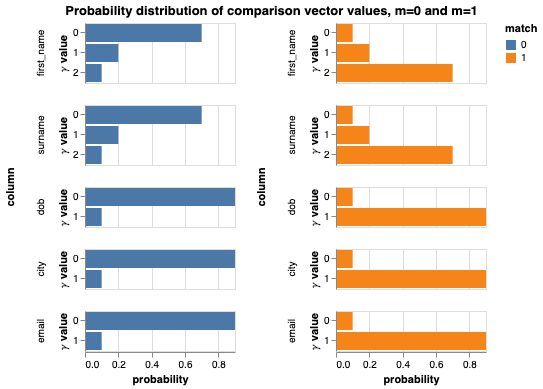

In [10]:
# Note there are various graphical representations of the information contained in parameters, such as:
params.probability_distribution_chart()

## Step 5:  Repeatedly apply expectation and maximisation step to improve parameter estimates

In [11]:
from sparklink.iterate import iterate
logging.getLogger("sparklink").setLevel(logging.INFO)
df_e = iterate(df_gammas, spark, params, num_iterations=20, compute_ll=True)

INFO:sparklink.expectation_step:
Log likelihood for iteration 0:  -20843.84363503703

INFO:sparklink.expectation_step:
Log likelihood for iteration 1:  -15082.669796397964

INFO:sparklink.expectation_step:
Log likelihood for iteration 2:  -14873.744238786378

INFO:sparklink.expectation_step:
Log likelihood for iteration 3:  -14844.01762792252

INFO:sparklink.expectation_step:
Log likelihood for iteration 4:  -14834.844563328736

INFO:sparklink.expectation_step:
Log likelihood for iteration 5:  -14830.10346002543

INFO:sparklink.expectation_step:
Log likelihood for iteration 6:  -14827.276937750017

INFO:sparklink.expectation_step:
Log likelihood for iteration 7:  -14825.502832387934

INFO:sparklink.expectation_step:
Log likelihood for iteration 8:  -14824.351508743566

INFO:sparklink.expectation_step:
Log likelihood for iteration 9:  -14823.585865253537

INFO:sparklink.expectation_step:
Log likelihood for iteration 10:  -14823.066024661575

INFO:sparklink.expectation_step:
Log likeliho

## Step 6: Inspect results 



In [12]:
# Inspect main dataframe that contains the match scores
df_e.toPandas().sample(5)

,unique_id_l,unique_id_r,first_name_l,first_name_r,surname_l,surname_r,dob_l,dob_r,city_l,city_r,email_l,email_r,gamma_0,gamma_1,gamma_2,gamma_3,gamma_4,prob_gamma_0_non_match,prob_gamma_0_match,prob_gamma_1_non_match,prob_gamma_1_match,prob_gamma_2_non_match,prob_gamma_2_match,prob_gamma_3_non_match,prob_gamma_3_match,prob_gamma_4_non_match,prob_gamma_4_match,match_probability
1129,422,517,Brown,Brown,Emily,Martha,2005-07-15,2002-09-01,London,Southend-on-Sea,sarahnron@mckinbey.com,watsonthomas@jones-stuart.biz,2,0,0,0,0,0.468350,0.56797,0.323075,0.378831,0.987258,0.137293,0.860542,0.235885,0.999965,0.132571,0.005175
4761,864,986,Leo,Ellis,Jones,Jones,1983-07-01,1997-11-18,Manchester,London,None,tammy46@bailey-lee.net,0,2,0,0,-1,0.530554,0.36519,0.676925,0.564735,0.987258,0.137293,0.860542,0.235885,1.000000,1.000000,0.015597
490,152,852,Harry,Harry,Hill,Bond,2017-10-23,1979-12-08,Sheffield,nonoL,zporter@robinson.com,alexanderthomas@reyes.com,2,0,0,0,0,0.468350,0.56797,0.323075,0.378831,0.987258,0.137293,0.860542,0.235885,0.999965,0.132571,0.005175
582,203,393,Jacob,Jacob,Evans,Roberts,1987-02-06,2004-01-27,Southend-on-Sea,London,barrygary@flores.com,ryannnble@bryat.info,2,0,0,0,0,0.468350,0.56797,0.323075,0.378831,0.987258,0.137293,0.860542,0.235885,0.999965,0.132571,0.005175
1929,765,849,Mason,Mason,Coilns,Francis,1975-05-21,1975-08-30,Birmingham,Mlton,christina86@cummings.com,mccormickjeremy@ramirez.net,2,0,0,0,0,0.468350,0.56797,0.323075,0.378831,0.987258,0.137293,0.860542,0.235885,0.999965,0.132571,0.005175


Note that the `params` object is updated during the process of iteration.

This means that if we inspect it again, we will see a new set of parameters - those that result from the application of the expectation maximiastion algorithm

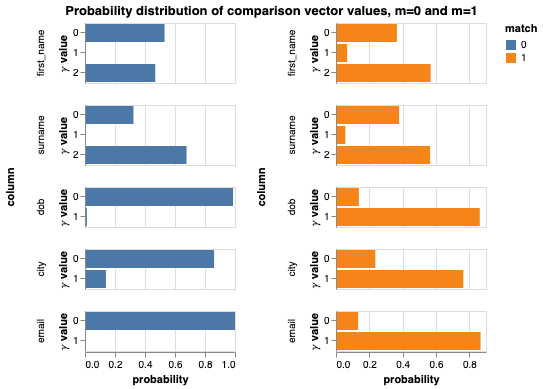

In [13]:
params.probability_distribution_chart()

An alternative representation of the parameters displays them in terms of the effect different values in the comparison vectors have on the match probability:

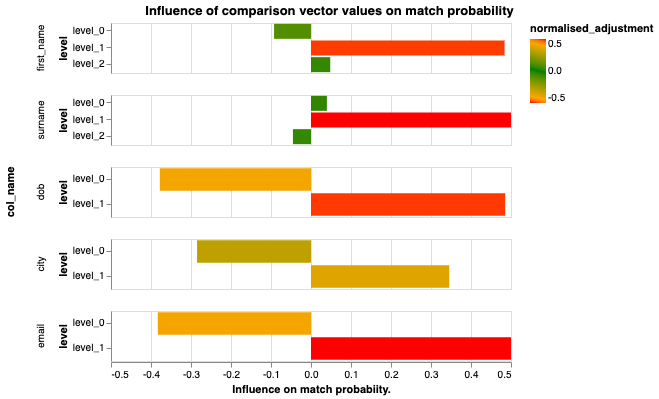

In [14]:
params.adjustment_factor_chart()

In [15]:
# If charts aren't displaying correctly in your notebook, you can write them to a file (by default sparklink_charts.html)
params.all_charts_write_html_file()

You can also generate a report which explains how the match probability was computed for an individual comparison row.  

Note that you need to convert the row to a dictionary for this to work

In [16]:
from sparklink.intuition import intuition_report
row_dict = df_e.toPandas().sample(1).to_dict(orient="records")[0]
print(intuition_report(row_dict, params))


Initial probability of match (prior) = λ = 0.4198944866657257

Comparison of first_name.  Values are:
first_name_l: Henry 
first_name_r: Henry 
Comparison has 3 levels
𝛾 for this comparison = gamma_0 = 2
Amongst matches, P(𝛾 = 0.5679703950881958):
Amongst non matches, P(𝛾 = 0.46834954619407654):
Adjustment factor = p1/(p1 + p2) = 0.548064716756707
New probability of match (updated belief): 0.46745802461454306

Comparison of surname.  Values are:
surname_l: Ali
surname_r: Ali
Comparison has 3 levels
𝛾 for this comparison = gamma_1 = 2
Amongst matches, P(𝛾 = 0.5647353529930115):
Amongst non matches, P(𝛾 = 0.6769246459007263):
Adjustment factor = p1/(p1 + p2) = 0.4548228609250236
New probability of match (updated belief): 0.4227352496650428

Comparison of dob.  Values are:
dob_l: 2012-11-30
dob_r: 2013-02-12
Comparison has 2 levels
𝛾 for this comparison = gamma_2 = 0
Amongst matches, P(𝛾 = 0.1372930258512497):
Amongst non matches, P(𝛾 = 0.9872581362724304):
Adjustment factor = p1/(p1 + p

## Step 7: Term frequency adjustments

Sparklink enables you to make adjustments for term frequency on any number of columns

This enables match probabilities to be adjusted for e.g. the fact John Smith is more prevalent than Robin Linacre

In [17]:
from sparklink.term_frequencies import make_adjustment_for_term_frequencies
df_e_adj = make_adjustment_for_term_frequencies(df_e, params, ["first_name", "surname"], retain_adjustment_columns=True, spark=spark)

In [18]:
pdtf = df_e_adj.toPandas()
sam = pdtf.sample(10)
sam[["match_probability", "tf_adjusted_match_prob"] + list(pdtf.columns)]

,match_probability,tf_adjusted_match_prob,unique_id_l,unique_id_r,first_name_l,first_name_r,surname_l,surname_r,dob_l,dob_r,city_l,city_r,email_l,email_r,gamma_0,gamma_1,gamma_2,gamma_3,gamma_4,prob_gamma_0_non_match,prob_gamma_0_match,prob_gamma_1_non_match,prob_gamma_1_match,prob_gamma_2_non_match,prob_gamma_2_match,prob_gamma_3_non_match,prob_gamma_3_match,prob_gamma_4_non_match,prob_gamma_4_match,match_probability,first_name_adj,surname_adj,tf_adjusted_match_prob
1541,0.018623,0.005522,574,819,George,George,Williams,Hill,1981-08-06,1984-03-16,London,None,desek58gibbr.biz,smithmelinda@christensen-harvey.com,2,0,0,-1,0,0.468350,0.56797,0.323075,0.378831,0.987258,0.137293,1.000000,1.000000,0.999965,0.132571,0.018623,0.226376,0.500000,0.005522
5535,1.000000,1.000000,805,811,Darcy,None,Webster,rebstW,1984-02-07,1984-02-07,Coschelte,Colchester,iatherine96@kkm-martinez.co,katherine96@kim-martinez.com,-1,0,1,1,1,1.000000,1.00000,0.323075,0.378831,0.012742,0.862707,0.139458,0.764115,0.000035,0.867429,1.000000,0.500000,0.500000,1.000000
1925,1.000000,1.000000,761,762,Collins,Collins,Mason,Mason,1975-05-21,1975-05-21,Birmingham,Birmingham,christina86@cummings.com,christina86@cummings.com,2,2,1,1,1,0.468350,0.56797,0.676925,0.564735,0.012742,0.862707,0.139458,0.764115,0.000035,0.867429,1.000000,0.582624,0.583806,1.000000
2507,0.003042,0.000619,63,93,Maya,None,Jones,Jones,2010-08-05,2003-11-25,Sunderland,Brighton,erin01@york.com,samuel91@curry.info,-1,2,0,0,0,1.000000,1.00000,0.676925,0.564735,0.987258,0.137293,0.860542,0.235885,0.999965,0.132571,0.003042,0.500000,0.168617,0.000619
5430,0.999996,0.999996,668,669,Taylor,Ivy,Ivy,Taylor,1980-01-13,1980-01-13,London,Lodno,jonesjennifer@pitts.com,jonesjennifer@pitts.com,0,0,1,0,1,0.530554,0.36519,0.323075,0.378831,0.012742,0.862707,0.860542,0.235885,0.000035,0.867429,0.999996,0.500000,0.500000,0.999996
86,0.125213,0.147436,21,529,Oliver,Oliver,Connolly,Cok,1972-03-08,2013-03-24,Plymouth,None,None,None,2,0,0,-1,-1,0.468350,0.56797,0.323075,0.378831,0.987258,0.137293,1.000000,1.000000,1.000000,1.000000,0.125213,0.547136,0.500000,0.147436
5163,0.999999,0.999999,374,381,Adam,Berry,Berry,Adam,1986-02-08,1986-02-08,None,nondo,walterdunn@pham-hill.com,walterdunn@pham-hill.com,0,0,1,-1,1,0.530554,0.36519,0.323075,0.378831,0.012742,0.862707,1.000000,1.000000,0.000035,0.867429,0.999999,0.500000,0.500000,0.999999
1055,0.999927,0.998643,368,369,Lewis,Lewis,Freddie,Freddie,1971-12-19,1971-09-14,Southend-on-Sea,Southend-on-Sea,tyler28@weaver-alvarez.com,tyler28@weaver-alvarez.com,2,2,0,1,1,0.468350,0.56797,0.676925,0.564735,0.987258,0.137293,0.139458,0.764115,0.000035,0.867429,0.999927,0.265110,0.129396,0.998643
1262,0.004416,0.001296,468,936,George,George,None,Hodgson,1984-07-05,1980-12-30,London,Sheffied,jonesjustin@myers.com,lori88@huynh.biz,2,-1,0,0,0,0.468350,0.56797,1.000000,1.000000,0.987258,0.137293,0.860542,0.235885,0.999965,0.132571,0.004416,0.226376,0.500000,0.001296
4741,0.022501,0.004647,858,880,Leo,None,Jones,Jones,1983-08-31,2019-06-15,Manchester,London,None,tcarr@lewis-kline.com,-1,2,0,0,-1,1.000000,1.00000,0.676925,0.564735,0.987258,0.137293,0.860542,0.235885,1.000000,1.000000,0.022501,0.500000,0.168617,0.004647
